# Q1

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import torch
import random

In [2]:
with h5py.File("full_dataset_vectors.h5", "r") as hf:    
    X_train = hf["X_train"][:]
    y_train = hf["y_train"][:]     
    X_test = hf["X_test"][:]  
    y_test = hf["y_test"][:]  

In [3]:
X_train = X_train.reshape(-1, 16, 16, 16, 1)
X_test = X_test.reshape(-1, 16, 16, 16, 1)

In [4]:
def apply_activation(X,activation):
    if(activation=='relu'):
        X = np.maximum(0,X)
    elif(activation=='tanh'):
        X = np.tanh(X)
    elif(activation=='sigmoid'):
        X = 1/(1+np.exp(-X))
    elif(activation=='leaky_relu'):
        X = [X if X>0 else 0.01*X]

    return X

def forward_pass_conv(X, kernel_size, no_of_filters, stride=1,padding=0, activation='relu'):
    in_channels=X.shape[3]

    d,h,w=kernel_size
    k=np.random.randn(d,h,w,in_channels,no_of_filters)*0.01

    # X_with_padding = np.pad(X,pad_width=padding,mode='constant',constant_values=0)
    X_with_padding = np.pad(X, pad_width=((padding,)*2,)*3 + ((0,0),), mode='constant', constant_values=0)
    D,H, W,_ = X_with_padding.shape

    output_D = (D-d)//stride + 1
    output_H = (H-h)//stride+1
    output_W = (W-w)//stride+1
    output = np.zeros((output_D,output_H, output_W, no_of_filters))

    for f in range(no_of_filters):
        for i in range(output_D):
            for j in range(output_H):
                for l in range(output_W):
                    output[i,j,l,f] = np.sum(X_with_padding[i*stride:i*stride+d, j*stride:j*stride+h, l*stride:l*stride+w, :] * k[:, :, :, :, f])

    return apply_activation(output,activation)

In [5]:
def display_cloud(data,title):
    fig = plt.figure(figsize=(8,8))
    ax=fig.add_subplot(111,projection='3d')
    x,y,z=np.where(data[:,:,:,0]>0.5)
    ax.scatter(x, y, z, c=data[x,y,z,0],cmap='viridis')
    ax.set_title(title)

def display_act_map(data,title):
    fig,axes=plt.subplots(2,2,figsize=(12,12))
    for i,ax in enumerate(axes.flat):
        if i < data.shape[3]:
            im=ax.imshow(data[:,:,8,i],cmap='viridis')
            ax.set_title(f'Filter {i+1}')
            plt.colorbar(im,ax=ax)

    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

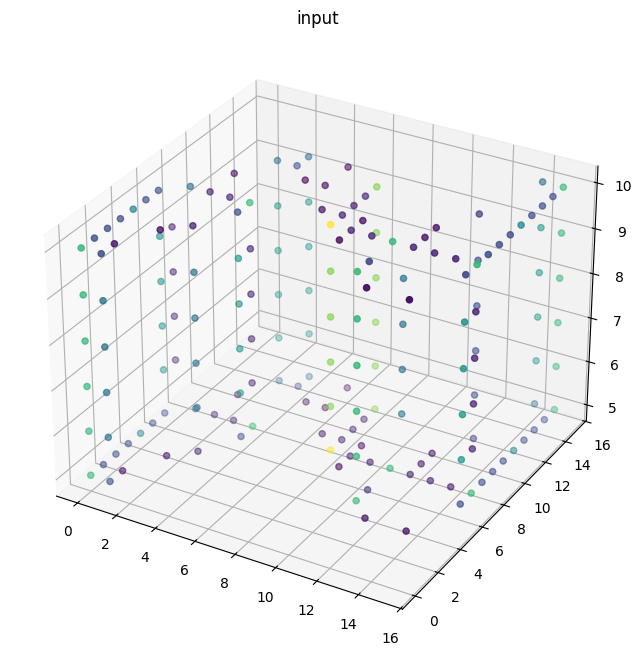

In [6]:
display_cloud(X_train[0],"input")

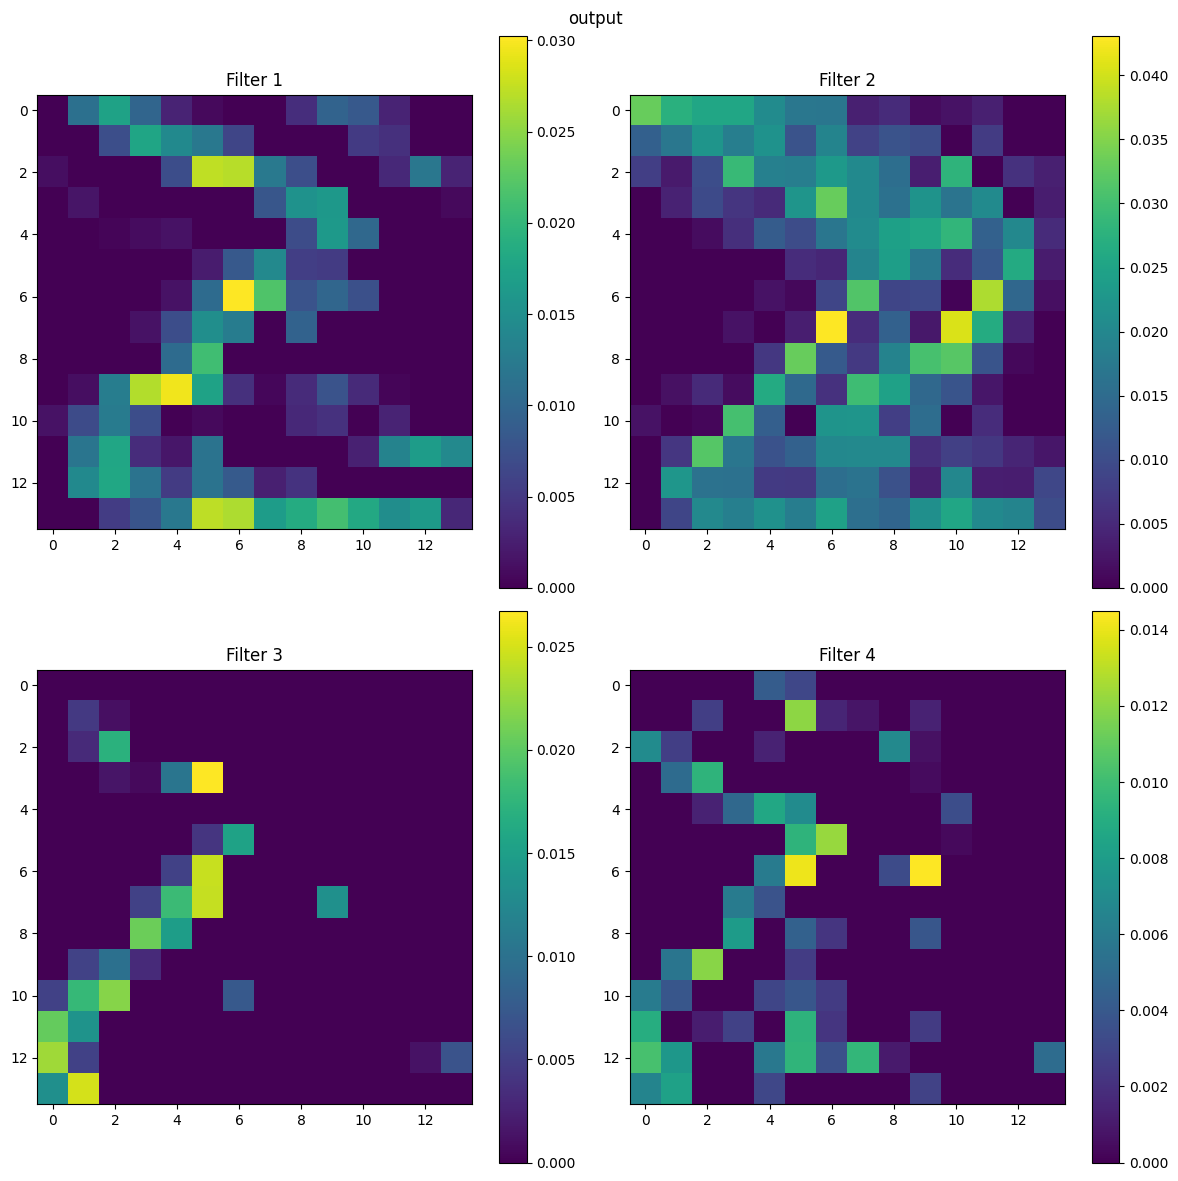

In [7]:
output=forward_pass_conv(X_train[0],kernel_size=(3,3,3),no_of_filters=4,activation='relu')
display_act_map(output,'output')

In [8]:
print(output.shape)

(14, 14, 14, 4)


In [9]:
def pooling(X, type='MAX', stride=1):
    D,H,W,in_channels=X.shape
    output_D=D//stride
    output_H=H//stride
    output_W=W//stride
    output = np.zeros((output_D,output_H,output_W,in_channels))

    for n in range(in_channels):
        for i in range(output_D):
            for j in range(output_H):
                for k in range(output_W):
                    pool = X[i*stride:i*stride+stride, j*stride:j*stride+stride, k*stride:k*stride+stride,n]
                    if(type=='MAX'):
                        output[i,j,k,n]=np.max(pool)
                    elif(type=='AVG'):
                        output[i,j,k,n]=np.mean(pool)
                
    
    return output

In [10]:
pool_output = pooling(output,'MAX',1)
pool_output.shape

(14, 14, 14, 4)

In [11]:
def local_and_global_pooling(X, type='MAX', stride=1):
    if(type=='GAP'):
        D,H,W,in_channels=X.shape
        output = np.zeros(in_channels)
        for n in range(in_channels):
            pool = X[:,:,:,:,n]
            output[n]=np,max(pool)
        
        return output
    else:
        return pooling(X,type,stride)

In [12]:
def softmax(x):
    return np.exp(x)/np.sum(np.exp(x))

def MLP(x, n_hidden_layer, hidden_layers_neurons,activation='relu'):

    for i in range(n_hidden_layer):
        if i == 0:
            w = np.random.randn(hidden_layers_neurons[i],x.shape[0])*0.01
            b = np.zeros((hidden_layers_neurons[i],1))
        else:
            w = np.random.randn(hidden_layers_neurons[i],hidden_layers_neurons[i-1])*0.01
            b = np.zeros((hidden_layers_neurons[i],1))

        s = np.dot(w,x)+b
        x = apply_activation(s,activation)

    w = np.random.randn(hidden_layers_neurons[-1],10)
    b = np.zeros((10,1))
    output = softmax(np.dot(w,x)+b)

    return output

In [13]:
# Apply convolution as asked

def CNN(X):
    # A 3D convolution layer with 16 filters of size 5 ×5 ×5 and ReLU activation.
    s1 = forward_pass_conv(X,kernel_size=(5,5,5),no_of_filters=16,activation='relu')

    # A Max Pooling 3D layer of size 2 ×2 ×2 with stride 2.
    s2 = local_and_global_pooling(s1,type='MAX',stride=2)

    # A 3D convolution layer with 32 filters of size 3 ×3 ×3 and ReLU activation.
    s3 = forward_pass_conv(s2,kernel_size=(3,3,3),no_of_filters=32,activation='relu')

    # A Max Pooling 3D layer of size 2 ×2 ×2 with stride 2.
    s4 = local_and_global_pooling(s3,type='MAX',stride=2)

    # A Global Average Pooling (GAP) layer.
    s5 = local_and_global_pooling(s4,type='GAP')

    # An MLP with one hidden layer, where the input size matches the output of the GAP layer and the output size is 10 (one for each digit class). The hidden layer should use ReLU activation, and the output layer should apply softmax activation
    s6 = MLP(s5,1,s5.shape,'relu')

    return s6

# Q2

In [134]:
def baseline_model(sequence):
    return 1

In [135]:
def count_balanced_paranthesis(s):
    open_paranthesis = ['[', '(', '<', '{']
    closed_paranthesis = {']':'[', ')':'(', '>':'<', '}':'{'}
    stack = []
    counter = 0
    for char in s:
        if(char in open_paranthesis):
            stack.append(char)
        elif(char in closed_paranthesis):
            if(len(stack)>=1 and stack[-1]==closed_paranthesis[char]):
                counter+=1
                stack.pop()

    return counter

In [136]:
import random

file_path = "assignment.cpp"
num_snippets = 5000       # Number of snippets you want
snippet_length_range = (10,100)

with open(file_path, "r", encoding="utf-8") as file:
    text = "".join(file.read().split())  # Remove all spaces and newlines

snippets = []
labels = []

for _ in range(num_snippets):
    snippet_length = random.randint(*snippet_length_range)
    start_index = random.randint(0, len(text) - snippet_length)
    snippet = text[start_index:start_index + snippet_length]
    snippets.append(snippet)
    labels.append(count_balanced_paranthesis(snippet))

# Save snippets and labels to the dataset to a text file
with open('output.csv', "w", encoding="utf-8") as file:
    for snippet, label in zip(snippets, labels):
        file.write(f"{snippet},{label}\n")

In [137]:
labels = []
for snippet in snippets:
    labels.append(count_balanced_paranthesis(snippet))

In [138]:
print(len(labels))

5000


In [139]:
characters = "abcdefghijklmonpqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ(){}[]<>.,/?@"

In [140]:
def letter_to_index(letter):
    return characters.find(letter) if letter in characters else -1

In [141]:
def sequence_to_tensor(sequence):
    tensor=torch.zeros(len(sequence),1,len(characters))
    for i, letter in enumerate(sequence):
        index = letter_to_index(letter)
        if(index != -1):
            tensor[i][0][letter_to_index(letter)]=1
    return tensor

In [142]:
import torch.nn as nn
import matplotlib.pyplot as plt

In [143]:
class RNN(nn.Module):
    def __init__(self,input_size,hidden_size,output_size):
        super(RNN,self).__init__()

        self.hidden_size=hidden_size
        self.input_to_hidden=nn.Linear(input_size+hidden_size,hidden_size)   # Input size = input_size+hidden_size, output size = hidden_size
        # self.input_to_output=nn.Linear(input_size+hidden_size,output_size)
        self.input_to_output=nn.Linear(hidden_size,output_size)
        self.relu=nn.ReLU()

    def forward(self,input_tensor,hidden_tensor):
        combined=torch.cat((input_tensor,hidden_tensor),1)

        hidden=self.relu(self.input_to_hidden(combined))
        output = self.input_to_output(hidden)
        return output,hidden
    
    def init_hidden(self):
        return torch.zeros(1,self.hidden_size)

In [144]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(snippets, labels, test_size=0.2)

hidden_size=128 #hyperparameter that we can define
rnn = RNN(len(characters),hidden_size,1)

In [145]:
criterion = nn.MSELoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)

def training(sequence_tensor,label):
    hidden=rnn.init_hidden()

    for i in range(sequence_tensor.size()[0]):
        output, hidden = rnn(sequence_tensor[i],hidden)
    
    # loss = criterion(output,label)
    loss = criterion(output.squeeze(), torch.tensor([label], dtype=torch.float))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return output.item(),loss.item()

In [ ]:
current_loss=0
all_losses=[]
plot_steps,print_steps=1000,5000
no_of_iterations = 100000

for i in range(len(X_train)):
    label = y_train[i]
    sequence = X_train[i]
    sequence_tensor = sequence_to_tensor(sequence)
    output,loss = training(sequence_tensor,label)

/Users/ahmikvirani/.pyenv/versions/3.11.5/lib/python3.11/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [147]:
def predict(sequence):
    with torch.no_grad():
        sequence_tensor=sequence_to_tensor(sequence)
        hidden=rnn.init_hidden()

        for i in range(sequence_tensor.size()[0]):
            output,hidden=rnn(sequence_tensor[i],hidden)
        
        # print(output)

        return output.item()

In [148]:
print(X_train)

['s="0x"+binary_to_hex(bin_address,false,5);stringbin_set=decimal_to_binary(', ';break;}}//Ifwedidnotfindthevalue,weneedtolookinthememoryif(', 'iourspartsoftheinstrutionstringopcode="0110011";stringf3=funct3[assembly', 'moryif(removed_data[1]==1){is_dirty=true;intto_store_mem_loc=0;to_store_mem_loc|=(tag', ';}elseif(registers.find(assembly_code[instr', '=registers.end(', 'ctions.top().first;i', 'ack();PC=0;while(getline(instruction_file,instruction)){//Iftheinstructionisdata,thenensurethatun', "h_back('0');fs.", 'tisfiedasperthegiveninstructionif(inst=="beq"){if(register_values[rs1]=', 'ex_instruction}for(inti=0;i<4;i++){memory[instruction_no*4+i]=byte[i];}}//CodeforSformatinstruc', '.size()){stringzeros="",fs="";for(inti=leng', 'xassociativity=cache_size/block_size;}intno_of_indexes=cache_size/(associativity*block_size);', 'truction_no][3]),6,true);imm="010000"+imm;}else{if(stoi(assembly_code[instruction_no][3])<-pow(2,11)', '//Concatinatingtheinstructio', 'tring,int>>dummy_stack;stac

In [149]:
# Check training error
predictions_train = []
for x in X_train:
    predictions_train.append(predict(x))

# print(mse_loss(predictions_train,y_train))
predictions_train_tensor = torch.tensor(predictions_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

training_error = criterion(predictions_train_tensor, y_train_tensor)
print(f"Training Error (MSE): {training_error.item()}")

Training Error (MSE): 2.511030912399292


In [153]:
predictions_test = []
for x in X_test:
    predictions_test.append(predict(x))

predictions_test_tensor = torch.tensor(predictions_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

testing_error = criterion(predictions_test_tensor, y_test_tensor)
print(f"Training Error (MSE): {testing_error.item()}")

Training Error (MSE): 2.7452914714813232


In [ ]:
predictions_baseline = []
for x in X_test:
    predictions_baseline.append(baseline_model(x))

predictions_baseline_tensor = torch.tensor(predictions_baseline, dtype=torch.float32)
y_test_baseline = torch.tensor(y_test, dtype=torch.float32)

baseline_error = criterion(predictions_baseline_tensor, y_test_baseline)
print(f"Testing Error (MSE): {baseline_error.item()}")

Training Error (MSE): 2.996999979019165


In [190]:
class LSTM(nn.Module):
    def __init__(self,input_size,hidden_size,output_size):
        super(LSTM,self).__init__()

        self.hidden_size=hidden_size

        self.W_f=nn.Linear(input_size+hidden_size,hidden_size) # Forget gate
        self.W_i=nn.Linear(input_size+hidden_size,hidden_size) # input gate
        self.W_o=nn.Linear(input_size+hidden_size,hidden_size) # output gate
        self.W_c=nn.Linear(input_size+hidden_size,hidden_size) # cell state update gate

        self.output_layer=nn.Linear(hidden_size,output_size)
        self.sigmoid=nn.Sigmoid()
        self.tanh=nn.Tanh()


    def forward(self,input_tensor,hidden_tensor,cell_tensor):

        combined=torch.cat((input_tensor,hidden_tensor),1) #Peephole connections

        f_t=self.sigmoid(self.W_f(combined))
        i_t=self.sigmoid(self.W_i(combined))
        o_t=self.sigmoid(self.W_o(combined))

        c_t_2 = self.tanh(self.W_c(combined))

        c_t=f_t*cell_tensor+i_t*c_t_2
        h_t=o_t*self.tanh(c_t)

        output = self.output_layer(h_t)
        return output,h_t,c_t
    
    def init_hidden(self):
        return torch.zeros(1,self.hidden_size), torch.zeros(1,self.hidden_size)

In [191]:
lstm = LSTM(len(characters),hidden_size,1)

In [192]:
criterion = nn.MSELoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

def lstm_training(sequence_tensor,label):
    h_t, c_t=lstm.init_hidden()

    for i in range(sequence_tensor.size()[0]):
        output, h_t, c_t = lstm(sequence_tensor[i],h_t, c_t)
        # output, h_t, c_t = lstm(sequence_tensor[i].unsqueeze(0),h_t, c_t)
    
    # loss = criterion(output,label)
    loss = criterion(output.squeeze(), torch.tensor([label], dtype=torch.float))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return output.item(),loss.item()

In [193]:
current_loss=0
all_losses=[]
plot_steps,print_steps=1000,5000
no_of_iterations = 100000

for i in range(len(X_train)):
    label = y_train[i]
    sequence = X_train[i]
    sequence_tensor = sequence_to_tensor(sequence)
    output,loss = lstm_training(sequence_tensor,label)

/Users/ahmikvirani/.pyenv/versions/3.11.5/lib/python3.11/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [194]:
def lstm_predict(sequence):
    with torch.no_grad():
        sequence_tensor=sequence_to_tensor(sequence)
        h_t,c_t=lstm.init_hidden()

        for i in range(sequence_tensor.size()[0]):
            output,h_t,c_t=lstm(sequence_tensor[i],h_t,c_t)
            # output,h_t,c_t=lstm(sequence_tensor[i].unsqueeze(0),h_t,c_t)
        
        # print(output)

        return output.item()

In [195]:
# Check training error
predictions_train = []
for x in X_train:
    predictions_train.append(lstm_predict(x))

# print(mse_loss(predictions_train,y_train))
predictions_train_tensor = torch.tensor(predictions_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

training_error = criterion(predictions_train_tensor, y_train_tensor)
print(f"Training Error (MSE): {training_error.item()}")

Training Error (MSE): 1.32125723361969


In [196]:
predictions_test = []
for x in X_test:
    predictions_test.append(lstm_predict(x))

predictions_test_tensor = torch.tensor(predictions_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

testing_error = criterion(predictions_test_tensor, y_test_tensor)
print(f"Testing Error (MSE): {testing_error.item()}")

Testing Error (MSE): 1.4481765031814575


In [197]:
class GRU(nn.Module):
    def __init__(self,input_size,hidden_size,output_size):
        super(GRU,self).__init__()

        self.hidden_size=hidden_size

        self.W_z=nn.Linear(input_size+hidden_size,hidden_size) # update gate
        self.W_r=nn.Linear(input_size+hidden_size,hidden_size) # reset gate
        self.W=nn.Linear(input_size+hidden_size,hidden_size) # hidden state gate

        self.output_layer=nn.Linear(hidden_size,output_size)
        self.sigmoid=nn.Sigmoid()
        self.tanh=nn.Tanh()


    def forward(self,input_tensor,hidden_tensor):

        combined=torch.cat((hidden_tensor,input_tensor),1)

        z_t=self.sigmoid(self.W_z(combined))
        r_t=self.sigmoid(self.W_r(combined))
        h_t_2 = self.tanh(self.W(torch.cat((r_t*hidden_tensor,input_tensor),1)))
        h_t=(1-z_t)*hidden_tensor + z_t*h_t_2

        output = self.output_layer(h_t)
        return output,h_t
    
    def init_hidden(self):
        return torch.zeros(1,self.hidden_size)

In [198]:
gru = GRU(len(characters),hidden_size,1)

In [199]:
criterion = nn.MSELoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(gru.parameters(), lr=learning_rate)

def gru_training(sequence_tensor,label):
    h_t=gru.init_hidden()

    for i in range(sequence_tensor.size()[0]):
        output, h_t = gru(sequence_tensor[i],h_t)
    
    # loss = criterion(output,label)
    loss = criterion(output.squeeze(), torch.tensor([label], dtype=torch.float))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return output.item(),loss.item()

In [200]:
current_loss=0
all_losses=[]
plot_steps,print_steps=1000,5000
no_of_iterations = 100000

for i in range(len(X_train)):
    label = y_train[i]
    sequence = X_train[i]
    sequence_tensor = sequence_to_tensor(sequence)
    output,loss = gru_training(sequence_tensor,label)

/Users/ahmikvirani/.pyenv/versions/3.11.5/lib/python3.11/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [201]:
def gru_predict(sequence):
    with torch.no_grad():
        sequence_tensor=sequence_to_tensor(sequence)
        h_t=gru.init_hidden()

        for i in range(sequence_tensor.size()[0]):
            output,h_t=gru(sequence_tensor[i],h_t)

        return output.item()

In [202]:
# Check training error
predictions_train = []
for x in X_train:
    predictions_train.append(gru_predict(x))

# print(mse_loss(predictions_train,y_train))
predictions_train_tensor = torch.tensor(predictions_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

training_error = criterion(predictions_train_tensor, y_train_tensor)
print(f"Training Error (MSE): {training_error.item()}")

Training Error (MSE): 0.40617579221725464


In [203]:
predictions_test = []
for x in X_test:
    predictions_test.append(gru_predict(x))

predictions_test_tensor = torch.tensor(predictions_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

testing_error = criterion(predictions_test_tensor, y_test_tensor)
print(f"Testing Error (MSE): {testing_error.item()}")

Testing Error (MSE): 0.43395766615867615
